In [17]:
import librosa
import numpy as np
import pretty_midi
import soundfile as sf
import noisereduce as nr
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

### Load MP3 of Isolated Bass

In [18]:
input_filename = "mp3_input/bass_NGHYB.mp3"
input_cleaned_filename = "mp3_input/bass_NGHYB_clean.mp3"

output_raw_filename = "transcribed_output/bass_NGHYB_raw_transcribed.mid"
output_filename = "transcribed_output/bass_NGHYB_transcribed.mid"

y, sr = librosa.load(input_filename, sr=None, mono=True)  # keep original sample rate

### Clean up Bass  
Remove anything outside 40-400Hz

In [19]:
# ----------------------------
# 2. Band-pass filter (40–400 Hz for 4-string bass)
# ----------------------------
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=40.0, highcut=400.0, fs=44100, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

In [20]:
#keep only frequencies which the 4 string bass is capable of

y_band = bandpass_filter(y, lowcut=40.0, highcut=400.0, fs=sr)

In [21]:
sf.write(input_cleaned_filename, y_band, sr)

In [22]:
audio, sr = librosa.load(input_cleaned_filename)

### MP3 to Midi

In [23]:
hop_length = 512 # default

In [24]:
f0 = librosa.yin(y=audio, fmin=40, fmax=400, sr=sr)
times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)

In [25]:
# Convert frequencies → MIDI notes
def hz_to_midi(hz):
    if hz <= 0 or np.isnan(hz):
        return None
    return int(round(69 + 12 * np.log2(hz / 440.0)))

midi_notes = [hz_to_midi(freq) for freq in f0]

Plot First 500 Samples

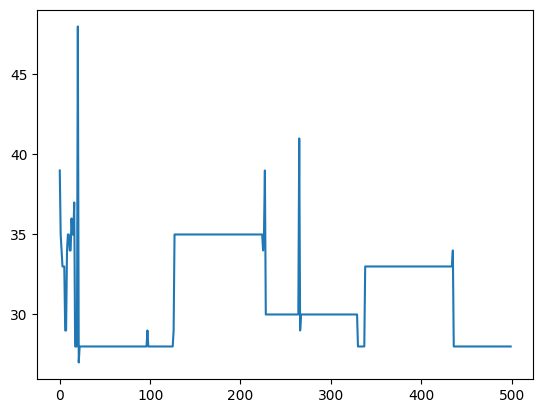

In [26]:
plt.plot(midi_notes[:500])

Convert to Midi

In [27]:
noise_window = 1

# build midi from sequence of midi notes 
# Build MIDI file
midi = pretty_midi.PrettyMIDI()
bass_program = pretty_midi.instrument_name_to_program("Acoustic Bass")
bass = pretty_midi.Instrument(program=bass_program)

# Group frames into sustained notes
current_note = None
note_start = None

for i, note in enumerate(midi_notes):
    if note is not None:
        if current_note is None:  # new note
            current_note = note
            note_start = times[i]
        elif not((current_note - noise_window) < note < (current_note + noise_window)):  # pitch change → close old note, start new
            bass.notes.append(pretty_midi.Note(
                velocity=100, pitch=current_note,
                start=note_start, end=times[i]
            ))
            current_note = note
            note_start = times[i]
    else:
        if current_note is not None:  # end current note
            bass.notes.append(pretty_midi.Note(
                velocity=100, pitch=current_note,
                start=note_start, end=times[i]
            ))
            current_note = None
            note_start = None

# If song ends with a note still playing
if current_note is not None:
    bass.notes.append(pretty_midi.Note(
        velocity=100, pitch=current_note,
        start=note_start, end=times[-1]
    ))

midi.instruments.append(bass)

In [28]:
### Save Raw Midi
midi.write(output_raw_filename)

### Clean up Midi

In [29]:
instrument = midi.instruments[0]

In [30]:
# ----------------------------
# Define helpers
# ----------------------------
def quantize_time(time, grid_size, pm):
    """Quantize a time value to the nearest grid point."""
    # Get beat grid from PrettyMIDI
    beats = pm.get_beats()
    if len(beats) < 2:
        return time  # no tempo info, skip

    # Grid spacing in seconds
    grid = np.arange(beats[0], beats[-1], grid_size)
    return grid[np.argmin(np.abs(grid - time))]

Removes any Short Noises

In [31]:
min_length = 0.12

cleaned_notes = []
for note in instrument.notes:
    # # Keep only notes in 4-string bass range (E1=40 to G4=67 in MIDI numbers)
    # if 40 <= note.pitch <= 67:
    # Remove very short noise notes (< 60 ms)
    if note.end - note.start > min_length:
        # Clamp velocities to a usable range
        note.velocity = min(max(note.velocity, 40), 100)

        # Quantize note start and end to nearest 1/16th note
        quantized_start = quantize_time(note.start, 0.25, midi)  # quarter-note subdivisions
        quantized_end = quantize_time(note.end, 0.25, midi)

        # Ensure quantized_end > quantized_start
        if quantized_end <= quantized_start:
            quantized_end = quantized_start + 0.1

        note.start = quantized_start
        note.end = quantized_end

        cleaned_notes.append(note)

In [32]:
# Replace notes with cleaned list
instrument.notes = cleaned_notes

### Save

In [33]:
# Save cleaned MIDI
midi.write(output_filename)